## Calculating shifted correlations

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate the correlation between a record of oxygen isotope data from Leviathan cave and insolation and various latitudes and seasons. It shows how the strength and timing of the relationship changes depending on which month we choose for our insolation curve.

The notebook is structured as follows:

1. Define a function that will be used to calculate correlations between records that contain large hiatuses
3. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
4. Calculate correlation between shifted insolation and oxygen isotope data from Leviathan cave
7. Plot results

In [1]:
# Importing relevant packages

import math
import pickle

import pyleoclim as pyleo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

Tokenization took: 1.61 ms
Type conversion took: 0.94 ms
Parser memory cleanup took: 0.00 ms


In [ ]:
# Importing the data

with open("../../data/geo_ms_composite_dict.pkl", "rb") as handle:
    geo_ms = pickle.load(handle)

In [ ]:
# Extracting the data

leviathan = geo_ms["Leviathan.Nevada.2017"]

This is the same correlation function from the Toy Data Heuristic notebook. See that notebook for more details.

In [ ]:
# Correlation function for series with gaps


def correlate_hiatus_series(series1, series2, cutoff_scale1=None):
    """Function to correlate series with large gaps. This is done by segmenting the time series, smoothing (if this is desired),
    and then reconnecting the time series with a dummy time axis so as not to re-introduce the hiatuses.

    series1 : pyleoclim.Series
        One series to correlate, presumed to have hiatuses
    series2 : pyleoclim.Series
        Other series to correlate, presumed to not have hiatuses
    cutoff_scale : int
        Cutoff scale for smoothing for series 1
    """

    if cutoff_scale1:
        segments = series1.segment()
        if isinstance(segments, pyleo.core.multiplegeoseries.MultipleGeoSeries):
            smoothed_series_value = []
            smoothed_series_time = []
            for segment in segments.series_list:
                if max(segment.time) - min(segment.time) > 6:
                    segment_smooth = segment.interp().filter(cutoff_scale=cutoff_scale1)
                    smoothed_series_value.extend(segment_smooth.value)
                    smoothed_series_time.extend(segment_smooth.time)
            smoothed_series = series1.copy()
            smoothed_series.value = smoothed_series_value
            smoothed_series.time = smoothed_series_time
        else:
            smoothed_series = series1.interp().filter(cutoff_scale=cutoff_scale1)
        series1 = smoothed_series

    smoothed_segments = series1.segment()
    series1_values = []
    series2_values = []
    if isinstance(smoothed_segments, pyleo.core.multiplegeoseries.MultipleGeoSeries):
        for segment in smoothed_segments.series_list:
            ms = pyleo.MultipleSeries([segment, series2]).common_time()
            s1, s2 = ms.series_list
            series1_values.extend(s1.value)
            series2_values.extend(s2.value)
        assert len(series1_values) == len(series2_values)
        time = np.arange(len(series1_values))
        s1_corr = pyleo.Series(time=time, value=series1_values, verbose=False)
        s2_corr = pyleo.Series(time=time, value=series2_values, verbose=False)
    else:
        s1_corr = series1
        s2_corr = series2

    corr = s1_corr.correlation(s2_corr, number=1, mute_pbar=True)

    return corr

Creating insolation curves using climlab.

In [ ]:
# Creating insolation objects

lat_list = np.arange(0, 81, 5)
inso_dict = {}

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

day_dict = {
    "June 21": [152],
    "July 21": [202],
    "August 21": [233],
    "JJA": np.arange(152, 243),
}

for day, num in day_dict.items():
    inso_dict[day] = {}
    for lat in lat_list:
        if len(num) > 1:
            inso = inso = daily_insolation(lat=lat, day=num, orb=orb).mean(dim="day")
        else:
            inso = daily_insolation(lat=lat, day=num[0], orb=orb)
        inso_series = pyleo.Series(
            time=0 - years[::-1],
            value=inso[::-1],
            time_name="Age",
            time_unit="Kyr BP",
            value_name=f"{day} : {np.abs(lat)} S",
            value_unit="W/m^2",
            verbose=False,
        )
        inso_dict[day][lat] = inso_series

Calculating correlation between insolation and shifted versions of the Leviathan record:

In [ ]:
# Calculating correlations between insolation and Leviathan

shift_array = np.arange(0, 8.1, 0.5)
# shift_array = np.arange(-8,8.1,2)
series_shift_dict = {shift: {} for shift in shift_array}

orig_series = leviathan.convert_time_unit("kyr BP").flip()
lat = leviathan.lat

for day in day_dict.keys():
    inso_lat_dict = inso_dict[day]
    for shift in shift_array:
        series = orig_series.copy()
        series.time += shift

        corr_res = {}
        for corr_lat, corr_series in inso_lat_dict.items():
            corr = correlate_hiatus_series(
                series1=series, series2=corr_series, cutoff_scale1=5
            )
            corr_res[corr_lat] = [corr.p, corr.r]

        correlated_inso = []

        for corr_lat, res in corr_res.items():
            corr_p, corr_r = res
            correlated_inso.append([corr_lat, corr_p, corr_r])

        series_shift_dict[shift][day] = correlated_inso

Loading data into a pandas DataFrame for plotting:

In [ ]:
# Putting data into a DataFrame

series_df_dict = {}

for day in day_dict.keys():
    columns = [math.ceil(a) for a in shift_array * 1000]
    df = pd.DataFrame(index=np.arange(5, 81, 5), columns=columns)
    for shift in shift_array:
        corr_list = series_shift_dict[shift][day]
        for corr in corr_list:
            lat = np.abs(corr[0])
            r = corr[2]
            df.loc[lat, math.ceil(shift * 1000)] = r**2
    series_df_dict[day] = df

Plotting results:

Text(0.5, 1.05, 'Leviathan')

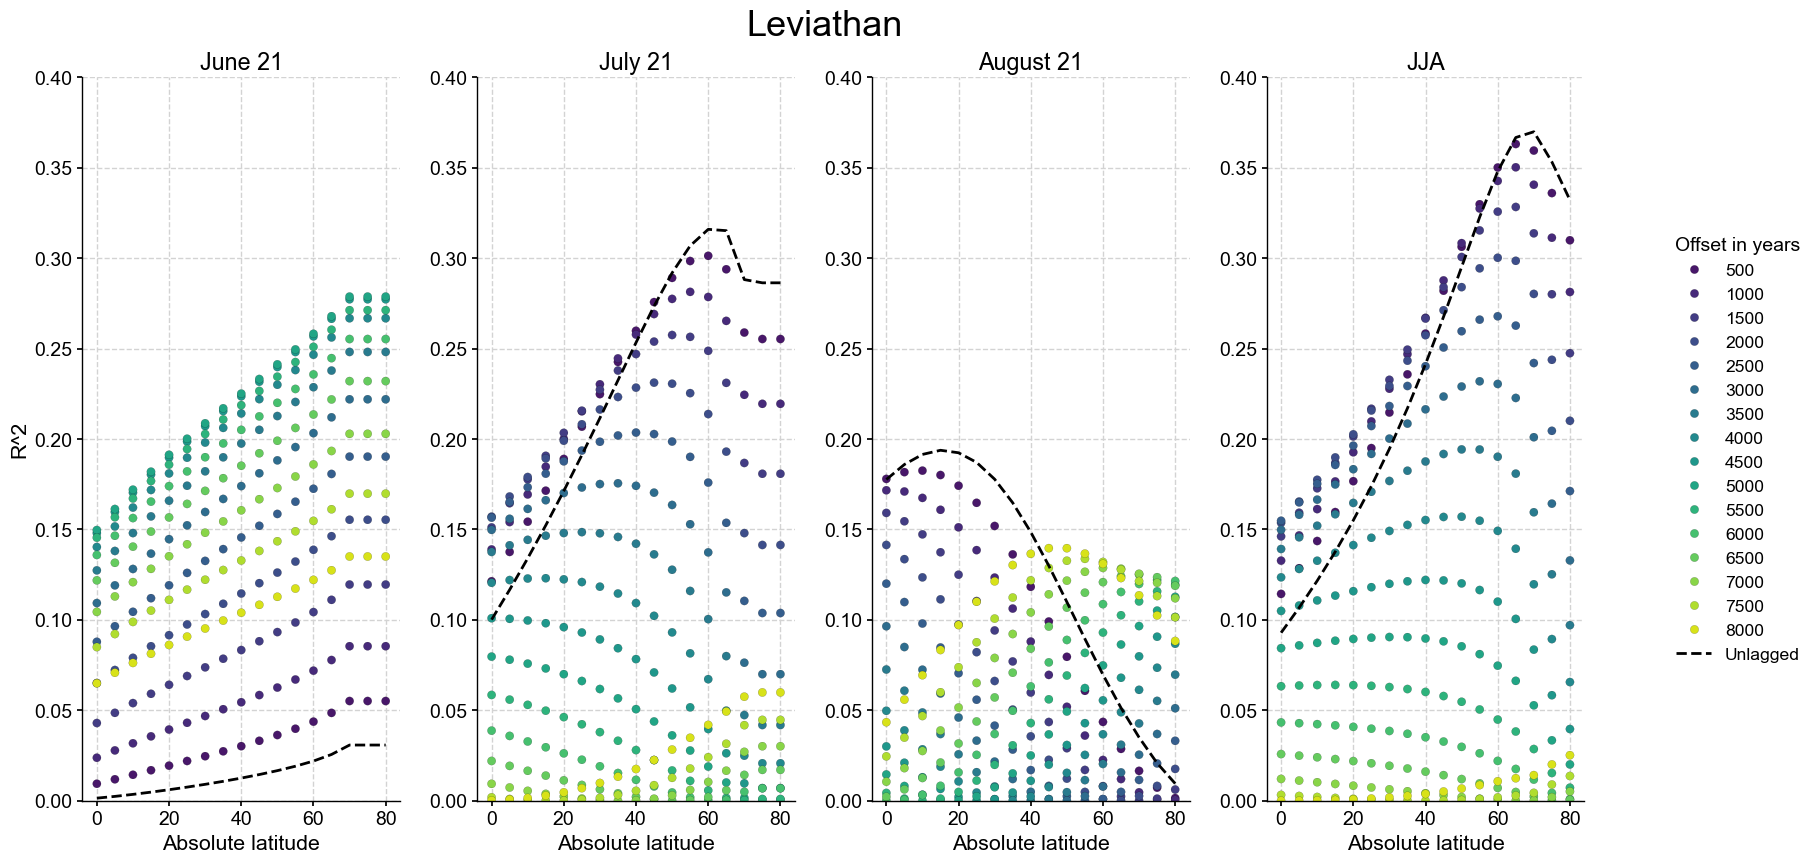

In [ ]:
# Plotting the data

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))
# fig.subplots_adjust(wspace=0.6, hspace=0.4)
fig.tight_layout()

axes = ax.ravel()
colors = sns.color_palette("colorblind")

for idx, pair in enumerate(series_df_dict.items()):
    label, df = pair
    scatter_df = df.drop(labels=0, axis=1)
    sns.scatterplot(
        scatter_df,
        ax=axes[idx],
        legend=True,
        palette="viridis",
        markers=["o" for _ in scatter_df.columns],
        edgecolor="black",
        linewidth=0.1,
    )
    sns.lineplot(
        x=df[0].index.to_numpy(),
        y=df[0].to_numpy(),
        ax=axes[idx],
        linestyle="--",
        color="black",
        label="Unlagged",
    )

    if idx == len(series_df_dict.keys()) - 1:
        handles, labels = axes[idx].get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            loc="center right",
            bbox_to_anchor=[1.12, 0.5],
            title="Offset in years",
        )

    if idx in [0]:
        axes[idx].set_ylabel("R^2")

    axes[idx].set_xlabel("Absolute latitude")
    axes[idx].get_legend().remove()
    axes[idx].set_title(f"{label.split('.')[0]}")
    axes[idx].set_ylim(0, 0.4)

plt.suptitle("Leviathan", y=1.05, fontsize=26)